In [1]:
import h5py
import tensorflow as tf
import numpy as np
import time
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error

In [2]:
# prepare dataset
hf = h5py.File('/home/amitkrkc/bucket/mESC_h5/feature_all_chromosome_2017Jan02.h5')
train_input = hf['train_input']
train_output = hf['train_output']
train_output = np.reshape(train_output, [train_output.shape[0],1])

# separate between train and validate
validate_index = np.arange(0, train_input.shape[0], 4)
train_index = np.setdiff1d(np.arange(0, train_input.shape[0]), validate_index)

validate_input = train_input[validate_index,:]
validate_output = train_output[validate_index,:]
train_input = train_input[train_index,:]
train_output = train_output[train_index,:]


test_input = hf['validate_input']
test_output = hf['validate_output']
test_output = np.reshape(test_output, [test_output.shape[0],1])


print("Training input size:(%d, %d) \t output size:(%d, %d)"%(train_input.shape[0],train_input.shape[1],train_output.shape[0],train_output.shape[1]))
print("Validation input size:(%d, %d) \t output size:(%d, %d)"%(validate_input.shape[0],validate_input.shape[1],validate_output.shape[0],validate_output.shape[1]))
print("Test input size:(%d, %d) \t output size:(%d, %d)"%(test_input.shape[0],test_input.shape[1],test_output.shape[0],test_output.shape[1]))

Training input size:(8749, 1087) 	 output size:(8749, 1)
Validation input size:(2917, 1087) 	 output size:(2917, 1)
Test input size:(5834, 1087) 	 output size:(5834, 1)


In [3]:
# disply histogram of errors
def get_hist(gt, pred):
    err_val =(gt - pred)
    hh, bb = np.histogram(err_val, bins=50)
    hh = hh + 0.0000001
    hh = hh/sum(hh)

    mean_val = np.sum(np.dot(hh,bb[:-1]))
    sigma_val = np.sum(np.dot(hh, (bb[:-1]-mean_val)**2))
    
    return hh,bb[:-1],mean_val, sigma_val

def show_hist(a, train_output, mu_train_dl, xlabel='prediction error', ylabel='normalized frequency', title=''):
    hh,bb,mean_val, sigma_val = get_hist(train_output, mu_train_dl)
    a.plot(bb, hh)
    a.text(-25, 0.14, 'mu:%0.4f, sigma:%0.4f'%(mean_val, sigma_val), color='red')
    a.grid(True)
    
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    a.set_title(title)

def show_scatter_plot(pred, gt, a, title):
    a.plot(gt, pred,'o')
    a.set_title(title)
    a.set_xlabel("groundtruth")
    a.set_ylabel("prediction")
    a.grid(True)

In [4]:
def analyze_regressor(train_output, pred_train, 
                      validate_output, pred_validate, 
                      test_output, pred_test, is_display=True,
                     is_display_graph=True):
    
    # explained variances
    ev_train = 100*explained_variance_score(train_output, pred_train)
    ev_validate = 100*explained_variance_score(validate_output, pred_validate)
    ev_test = 100*explained_variance_score(test_output, pred_test)
    
    # mean-squared error
    mse_train = mean_squared_error(train_output, pred_train)
    mse_validate = mean_squared_error(validate_output, pred_validate)
    mse_test = mean_squared_error(test_output, pred_test)
    
    
    # mean-absoluate error
    mae_train = mean_absolute_error(train_output, pred_train)
    mae_validate = mean_absolute_error(validate_output, pred_validate)
    mae_test = mean_absolute_error(test_output, pred_test)
    
    
    # coeff. of determination variances
    r2_train = 100*r2_score(train_output, pred_train)
    r2_validate = 100*r2_score(validate_output, pred_validate)
    r2_test = 100*r2_score(test_output, pred_test)
    
    if is_display:
        print("Explained variance score(s): Train: %0.4f%%, Validate: %0.4f%%, Test: %0.4f%%"%(ev_train, ev_validate, ev_test))
        print("MSE : Train: %0.4f, Validate: %0.4f, Test: %0.4f"%(mse_train, mse_validate, mse_test))
        print("MAE : Train: %0.4f, Validate: %0.4f, Test: %0.4f"%(mae_train, mae_validate, mae_test))
        print("R2 score(s): Train: %0.4f%%, Validate: %0.4f%%, Test: %0.4f%%"%(r2_train, r2_validate, r2_test))
    
    if is_display_graph:
        # scatter plots
        _,a = plt.subplots(2,3,figsize=(12,10))
        show_scatter_plot(train_output, pred_train,a[0][0], "Train")
        show_scatter_plot(validate_output, pred_validate,a[0][1], "Validate")
        show_scatter_plot(test_output, pred_test,a[0][2], "Test")

        # error histograms
        show_hist(a[1][0], train_output, pred_train, title='Train')
        show_hist(a[1][1], validate_output, pred_validate, title='Validate')
        show_hist(a[1][2], test_output, pred_test, title='Test')

    return (mse_train, mse_validate, mse_test)

In [5]:
def analyze_linear_regressor(feat_index, is_display=True, is_display_graph=True):

    train_input1 = train_input[:, feat_index]
    validate_input1 = validate_input[:, feat_index]
    test_input1 = test_input[:, feat_index]

    # define a linear regressor
    reg_lin_self = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)

    # fit 
    reg_lin_self.fit(train_input1, train_output)

    # predict the expression levels and compute metrics
    pred_train = reg_lin_self.predict(train_input1)
    pred_validate = reg_lin_self.predict(validate_input1)
    pred_test = reg_lin_self.predict(test_input1)

    (mse_train, mse_validate, mse_test) = analyze_regressor(train_output, pred_train, validate_output, 
                                                            pred_validate, test_output, 
                                                            pred_test, is_display, is_display_graph)
    
    return (mse_train, mse_validate, mse_test)

In [6]:
from sklearn.linear_model import Lasso

def analyze_lasso_regressor(feat_index, alpha, is_display=True, is_display_graph=True):

    train_input1 = train_input[:, feat_index]
    validate_input1 = validate_input[:, feat_index]
    test_input1 = test_input[:, feat_index]

    # define a linear regressor
    reg_lasso = Lasso(alpha=alpha)

    # fit 
    reg_lasso.fit(train_input1, train_output)

    # predict the expression levels and compute metrics
    pred_train = reg_lasso.predict(train_input1)
    pred_validate = reg_lasso.predict(validate_input1)
    pred_test = reg_lasso.predict(test_input1)

    (mse_train, mse_validate, mse_test) = analyze_regressor(train_output, pred_train, 
                                                            validate_output, pred_validate, 
                                                            test_output, pred_test, 
                                                            is_display, is_display_graph)
    
    return np.array((mse_train, mse_validate, mse_test))

### linear regressor over self feature only

In [7]:
def print_format():
    print("Feature format: [0, 100) --> dist_j, [100, 800) --> feat_range_j, [800, 807) --> feat_i, [807,1087) --> feat_delta for 40 delta values")
                                                                                          

In [8]:
feat_index = np.arange(800, 807)
mse_self=analyze_linear_regressor(feat_index,is_display=True,is_display_graph=False)

Explained variance score(s): Train: 8.1032%, Validate: 7.8086%, Test: 6.9632%
MSE : Train: 6.6441, Validate: 6.3737, Test: 7.0613
MAE : Train: 1.3408, Validate: 1.3082, Test: 1.3650
R2 score(s): Train: 8.1032%, Validate: 7.7997%, Test: 6.9628%


### Linear regressor with self + delta

In [9]:
mse_self_delta = np.zeros((40,3)) # mse of all 

feat_self = np.arange(800, 807)

for delta_iter in range(0, 40):
    feat_delta_i = np.arange(807+7*delta_iter, 807+7*(delta_iter+1))

    feat_index = np.concatenate((feat_self, feat_delta_i))
    mse_self_delta[delta_iter,:] = analyze_linear_regressor(feat_index, is_display=False, 
                                                            is_display_graph=False)



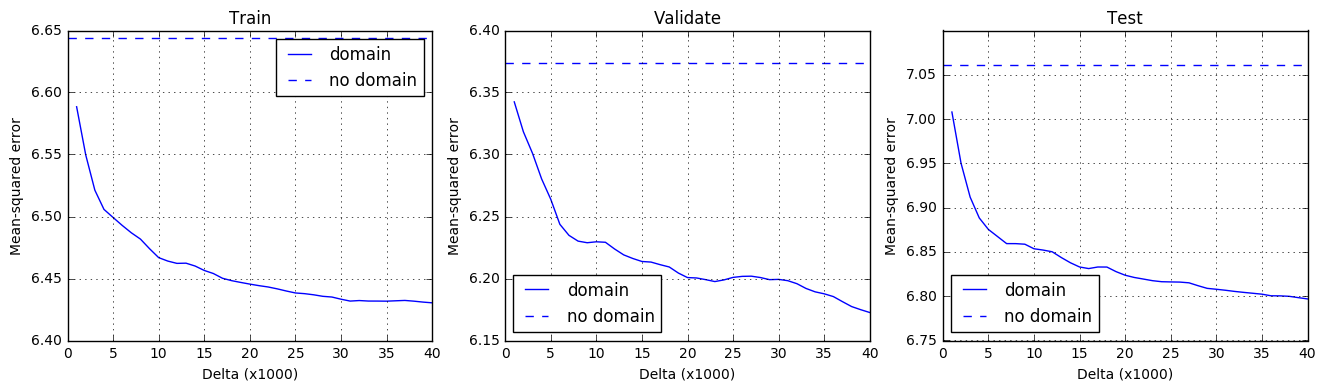

In [10]:
# display

xval = np.arange(1000, 41000, 1000)
_,a = plt.subplots(1,3, figsize=(16,4))

titles=('Train','Validate','Test')
for i in range(3):
    a[i].plot(xval/1000, mse_self_delta[:,i], label='domain')
    a[i].plot([0, 40],[mse_self[i], mse_self[i]],'b--',label='no domain')
    a[i].grid(True)
    a[i].set_title(titles[i])
    a[i].set_xlabel('Delta (x1000)')
    a[i].set_ylabel('Mean-squared error')
    a[i].legend(loc='best')


In [11]:
print_format()

Feature format: [0, 100) --> dist_j, [100, 800) --> feat_range_j, [800, 807) --> feat_i, [807,1087) --> feat_delta for 40 delta values


### self+neighborhood

In [12]:
feat_index = np.arange(0, 807)
mse_self_neigh = analyze_linear_regressor(feat_index,is_display=False, is_display_graph=False)

### self+neighborhood+delta

In [13]:
mse_self_neigh_delta = np.zeros((40,3)) # mse of all
feat_self = np.arange(0, 807)
for delta_iter in range(0, 40):
    feat_delta_i = np.arange(807+7*delta_iter, 807+7*(delta_iter+1))

    feat_index = np.concatenate((feat_self, feat_delta_i))
    mse_self_neigh_delta[delta_iter,:]=analyze_linear_regressor(feat_index, is_display=False,
                                                                is_display_graph=False)

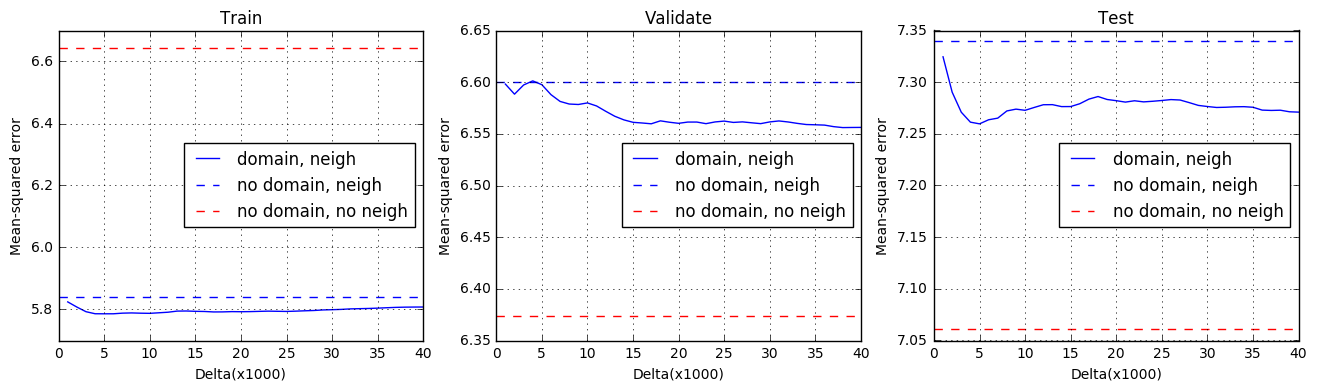

In [24]:
# display
xval = np.arange(1000, 41000, 1000)
_,a = plt.subplots(1,3, figsize=(16,4))

titles=('Train','Validate','Test')
for i in range(3):
    a[i].plot(xval/1000, mse_self_neigh_delta[:,i],label='domain, neigh')
    a[i].plot([0, 40],[mse_self_neigh[i], mse_self_neigh[i]],'b--',label='no domain, neigh')
    a[i].plot([0, 40],[mse_self[i], mse_self[i]],'r--',label='no domain, no neigh')
    a[i].grid(True)
    a[i].set_title(titles[i])
    a[i].set_xlabel('Delta(x1000)')
    a[i].set_ylabel('Mean-squared error')
    a[i].legend(loc='best')

### display all

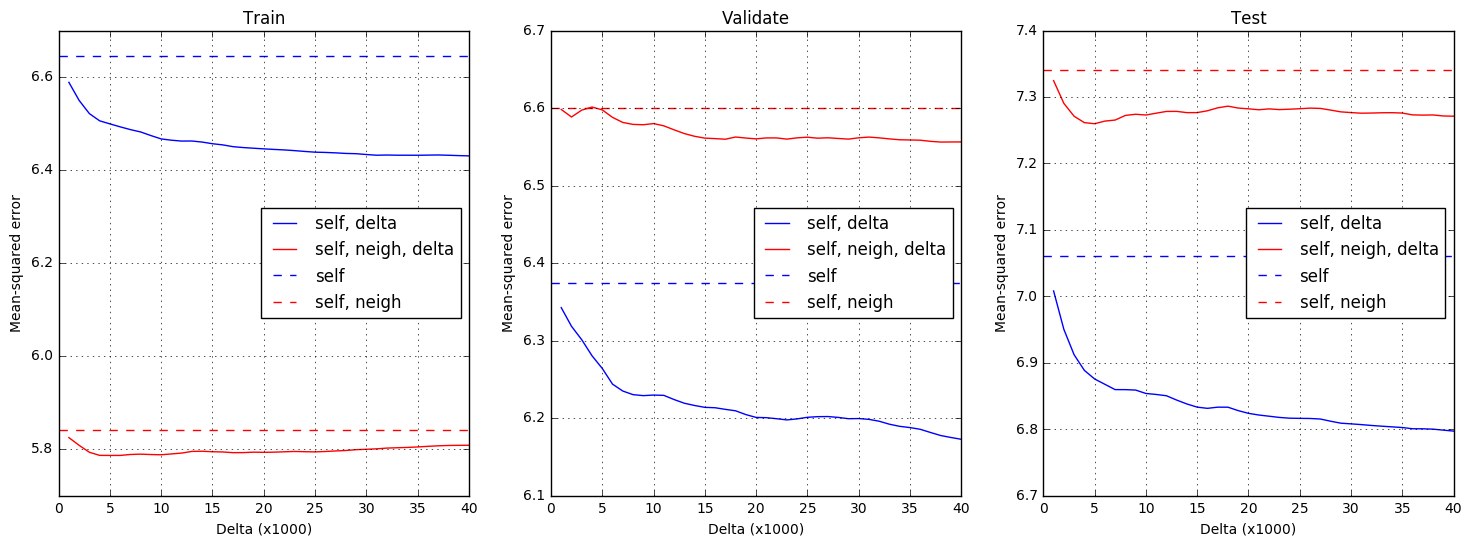

In [23]:
### all plots
# fig = plt.figure()

_,a = plt.subplots(1,3,figsize=(18,6))
xval = np.arange(1000, 41000, 1000)

# legend_labels = ('domain, no neigh','domain, neigh','no domain, no neigh','no domain, neigh')
legend_labels = ('self, delta','self, neigh, delta','self','self, neigh')

titles=('Train','Validate','Test')

for i in range(3):
    a[i].plot(xval/1000, mse_self_delta[:,i],label=legend_labels[0]) #'domain, no neigh')
    a[i].plot(xval/1000, mse_self_neigh_delta[:,i],'r', label=legend_labels[1]) # 'domain, neigh')
    a[i].plot([0, 40],[mse_self[i], mse_self[i]],'b--',label=legend_labels[2]) # 'no domain, no neigh')
    a[i].plot([0, 40],[mse_self_neigh[i], mse_self_neigh[i]],'r--',label=legend_labels[3]) #'no domain, neigh')
    
    a[i].grid(True)
    a[i].set_title(titles[i])
    a[i].set_xlabel('Delta (x1000)')
    a[i].set_ylabel('Mean-squared error')
    
    a[i].legend(loc='best')
    
# fig.legend()